In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Terrain Recognition**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
from tqdm import tqdm
import time
import copy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
import IPython
from IPython.display import display

In [2]:
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

# remove warnings
import warnings
warnings.filterwarnings("ignore")

def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [7]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
            T.RandomErasing(p=0.1, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [8]:
dataset_path = "/kaggle/input/terrain-recognition/Data Main/"

In [9]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [48]:
classes = get_classes("/kaggle/input/terrain-recognition/Data Main//train/")
num_classes=len(classes)
print("classes :",classes, ", number of classes :",num_classes)

classes : ['Grassy', 'Marshy', 'Rocky', 'Sandy'] , number of classes : 4


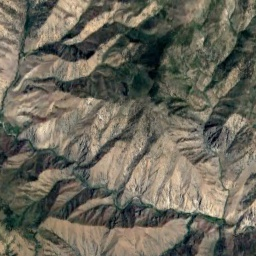

In [12]:
IPython.display.Image(filename='/kaggle/input/terrain-recognition/Data Main/test/Rocky/Rocky (1)_0_14.png') #Rocky 

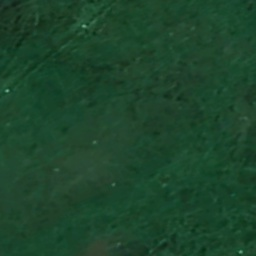

In [13]:
IPython.display.Image(filename='/kaggle/input/terrain-recognition/Data Main/test/Grassy/Grassy (7)_0_15.png') #Grassy

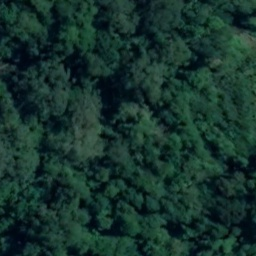

In [14]:
IPython.display.Image(filename='/kaggle/input/terrain-recognition/Data Main/test/Marshy/Marshy (1)_5_3.png') #Marshy

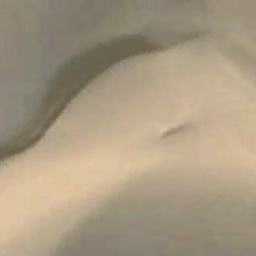

In [15]:
IPython.display.Image(filename='/kaggle/input/terrain-recognition/Data Main/test/Sandy/Sandy (7)_7_13.png') #Sandy

In [19]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [20]:
print(len(train_loader), len(val_loader), len(test_loader))

247 212 212


In [21]:
print(train_data_len, valid_data_len, test_data_len)

31571 6765 6769


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# **SWIN Transformer Model**

In [36]:
HUB_URL = "MaitreyaShelare/swin-transformer-model:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"

model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True)

Downloading: "https://github.com/MaitreyaShelare/swin-transformer-model/zipball/main" to /root/.cache/torch/hub/main.zip


In [37]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=4, bias=True)
)


In [29]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)

In [30]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [31]:
# Model Training
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [33]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10) 

Epoch 0/9
----------


100%|██████████| 247/247 [02:31<00:00,  1.63it/s]


train Loss: 0.4909 Acc: 0.9455


100%|██████████| 212/212 [00:30<00:00,  6.97it/s]


val Loss: 0.4088 Acc: 0.9854

Epoch 1/9
----------


100%|██████████| 247/247 [02:10<00:00,  1.89it/s]


train Loss: 0.4096 Acc: 0.9871


100%|██████████| 212/212 [00:26<00:00,  7.90it/s]


val Loss: 0.3912 Acc: 0.9923

Epoch 2/9
----------


100%|██████████| 247/247 [02:11<00:00,  1.89it/s]


train Loss: 0.3962 Acc: 0.9921


100%|██████████| 212/212 [00:26<00:00,  7.97it/s]


val Loss: 0.3815 Acc: 0.9941

Epoch 3/9
----------


100%|██████████| 247/247 [02:10<00:00,  1.90it/s]


train Loss: 0.3904 Acc: 0.9941


100%|██████████| 212/212 [00:26<00:00,  7.94it/s]


val Loss: 0.3800 Acc: 0.9950

Epoch 4/9
----------


100%|██████████| 247/247 [02:10<00:00,  1.89it/s]


train Loss: 0.3855 Acc: 0.9960


100%|██████████| 212/212 [00:26<00:00,  7.99it/s]


val Loss: 0.3778 Acc: 0.9953

Epoch 5/9
----------


100%|██████████| 247/247 [02:11<00:00,  1.88it/s]


train Loss: 0.3835 Acc: 0.9960


100%|██████████| 212/212 [00:26<00:00,  8.02it/s]


val Loss: 0.3746 Acc: 0.9965

Epoch 6/9
----------


100%|██████████| 247/247 [02:10<00:00,  1.89it/s]


train Loss: 0.3813 Acc: 0.9969


100%|██████████| 212/212 [00:26<00:00,  8.00it/s]


val Loss: 0.3756 Acc: 0.9963

Epoch 7/9
----------


100%|██████████| 247/247 [02:10<00:00,  1.89it/s]


train Loss: 0.3809 Acc: 0.9970


100%|██████████| 212/212 [00:26<00:00,  7.97it/s]


val Loss: 0.3742 Acc: 0.9967

Epoch 8/9
----------


100%|██████████| 247/247 [02:10<00:00,  1.89it/s]


train Loss: 0.3790 Acc: 0.9978


100%|██████████| 212/212 [00:26<00:00,  8.03it/s]


val Loss: 0.3711 Acc: 0.9976

Epoch 9/9
----------


100%|██████████| 247/247 [02:10<00:00,  1.89it/s]


train Loss: 0.3769 Acc: 0.9982


100%|██████████| 212/212 [00:26<00:00,  7.99it/s]

val Loss: 0.3713 Acc: 0.9972

Training complete in 26m 38s
Best Val Acc: 0.9976


In [38]:
#Model Testing
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))


100%|██████████| 212/212 [00:27<00:00,  7.74it/s]


Test Loss: 0.0009
Test Accuracy of Grassy: 99% (1814/1818)
Test Accuracy of Marshy: 99% (1641/1650)
Test Accuracy of Rocky: 99% (1640/1643)
Test Accuracy of Sandy: 100% (1641/1641)
Test Accuracy of 99% (6736/6752)


100%|██████████| 212/212 [00:27<00:00,  7.84it/s]


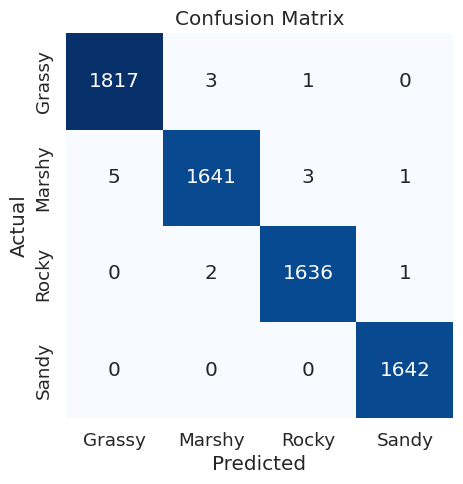

In [190]:
from sklearn.metrics import confusion_matrix

conf_matrix = np.zeros((len(classes), len(classes)), dtype=np.int)
model_ft.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            # Update the confusion matrix
            conf_matrix[label, pred[i].item()] += 1

# Calculate and display the confusion matrix
plt.figure(figsize=(5, 5))
class_names = classes
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# Saving the Best Model
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("terrain_recognition_swin.pt")

# **Implicit Properties Estimation**

In [133]:
!pip install patchify
import patchify
from PIL import Image
import cv2

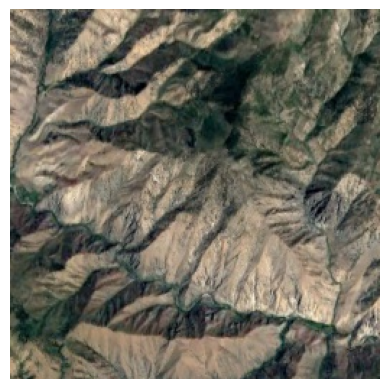

In [180]:
# Uncomment any one img at a time

img = cv2.imread('/kaggle/input/terrain-recognition/Data Main/test/Rocky/Rocky (1)_0_14.png') #Rocky
# img = cv2.imread('/kaggle/input/terrain-recognition/Data Main/test/Grassy/Grassy (7)_0_15.png') #Grassy
# img = cv2.imread('/kaggle/input/terrain-recognition/Data Main/test/Marshy/Marshy (1)_5_3.png') #Marshy
# img = cv2.imread('/kaggle/input/terrain-recognition/Data Main/test/Sandy/Sandy (7)_7_13.png') #Sandy

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.show()


In [181]:
img.shape

(256, 256, 3)

In [192]:
# Statistical Texture Analysis Approach
def implicitProperties(image):
    patch_list = []
    patches = patchify.patchify(np.asarray(img), patch_size=(32, 32, 3), step=32)
    
    for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
        patch = patches[i, j, 0, :, :, :]
        patch_list.append(patch)
        
    variance = []
    for i in range(len(patch_list)):
        temp_var = np.var(patch_list[i], axis=None)
        variance.append(temp_var)    
    
    roughness = []
    for i in range(len(variance)):
      v = variance[i]
      rough = 1 - (1/(1 + v))
      roughness.append(rough)
    
    data= np.zeros((8,8))
    b=0
    for r in range(8):
      for c in range(8):
        data[r,c] = roughness[b]
        b += 1

    heatmap = cv2.resize(data, (img.shape[1], img.shape[0]))

    heatmapshow = cv2.normalize(heatmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)
    
    alpha = 0.45  # transparency

    # Creating the overlay by blending the images
    overlay = cv2.addWeighted(img, 1 - alpha, heatmapshow, alpha, 0)

    # Displaying the overlayed image
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    return plt.show()

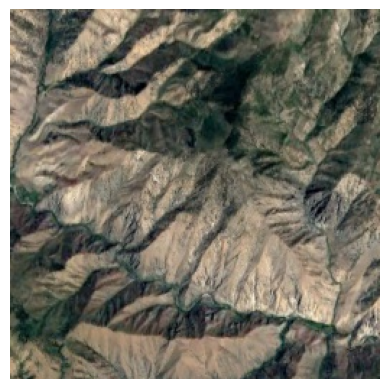

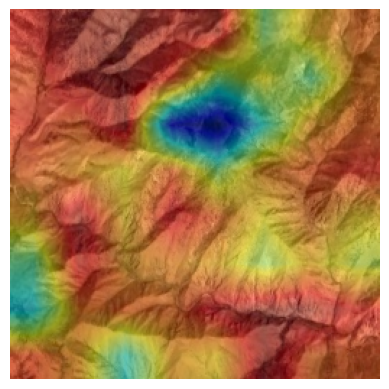

In [195]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.show()

implicitProperties(img)